Library Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import loguniform
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score

Data Imports

In [ ]:
#The GoEmotion dataset import:

!mkdir -p data/full_dataset
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df_GoEmotion_raw_data = pd.concat([
    pd.read_csv("data/full_dataset/goemotions_1.csv"),
    pd.read_csv("data/full_dataset/goemotions_2.csv"),
    pd.read_csv("data/full_dataset/goemotions_3.csv")
], ignore_index=True)

print(df_GoEmotion_raw_data.shape)

--2026-01-06 01:42:23--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  11.8MB/s    in 1.1s    

2026-01-06 01:42:24 (11.8 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2026-01-06 01:42:24--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
df_GoEmotion = df_GoEmotion_raw_data[df_GoEmotion_raw_data["example_very_unclear"] != True]

In [ ]:
#The dairAI Twitter Dataset import:

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df_dairAi_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_dairAI_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])
df_dairAI_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])

print(df_dairAi_train.shape)
print(df_dairAi_train.head)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(16000, 2)
<bound method NDFrame.head of                                                     text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]>


Changing the format of dairAi into GoEmotion's format


In [ ]:
datasetsDairAI = [df_dairAi_train, df_dairAI_test, df_dairAI_validation]

goemotions_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

dairai_labels = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def multiLabelFormat(df):
  for emotion in goemotions_labels:
    df[emotion] = 0

  for i, row in df.iterrows():
    label = row["label"]
    emo = dairai_labels[label]
    df.at[i, emo] = 1


for x in datasetsDairAI[0:2]:
    multiLabelFormat(x)
    x = x.drop(columns=["label"], inplace = True)

df_dairAI_test.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,im feeling rather rotten so im not very ambiti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,im updating my blog because i feel shitty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,i never make her separate from me because i do...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,i left with my bouquet of red and yellow tulip...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,i was feeling a little vain when i did this one,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Test Train Seperation for Go Emotion Dataset

In [ ]:
feature_columns = ["text"]
x = np.array(df_GoEmotion["text"]).reshape(-1, 1)
y = df_GoEmotion[goemotions_labels].values

In [ ]:
x_train_goEmotion, x_test, y_train_goEmotion, y_test = train_test_split(x, y, test_size=0.2, random_state=22)

I plan on dividing the x and Y values of dairAI dataset directly within the model.fit method

Model Implementation

Base Model:

Adding in the datasets of both datasets into one

In [ ]:
x_dairAi_train = df_dairAi_train["text"].values.reshape(-1, 1)
y_dairAi_train = df_dairAi_train[goemotions_labels].values.reshape(-1, 28)

x_train_goEmotion.shape, y_train_goEmotion.shape, df_dairAi_train["text"].values.reshape(-1, 1).shape, x_dairAi_train.shape, y_dairAi_train.shape

((166251, 1), (166251, 28), (16000, 1), (16000, 1), (16000, 28))

In [ ]:
x_train = np.concatenate([x_train_goEmotion, x_dairAi_train], axis=0)
y_train = np.concatenate([y_train_goEmotion, y_dairAi_train], axis=0)

x_train.shape, y_train.shape

((182251, 1), (182251, 28))

In [ ]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("1vsRest_Logistic", OneVsRestClassifier(
        LogisticRegression(max_iter=1000)
    ))])


baseline_clf.fit(x_train.flatten(), y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('1vsRest_Logistic',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [ ]:
y_pred_baseline = baseline_clf.predict(x_test.flatten())
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline accuracy: {baseline_acc:.4f}\n")
print("Baseline classification report:")
print(classification_report(y_test, y_pred_baseline, target_names=goemotions_labels))

Baseline accuracy: 0.1335

Baseline classification report:
                precision    recall  f1-score   support

    admiration       0.68      0.26      0.37      3443
     amusement       0.63      0.29      0.39      1921
         anger       0.54      0.08      0.14      1619
     annoyance       0.38      0.02      0.04      2701
      approval       0.53      0.03      0.05      3465
        caring       0.55      0.05      0.08      1195
     confusion       0.55      0.04      0.07      1522
     curiosity       0.52      0.05      0.10      1995
        desire       0.45      0.05      0.10       771
disappointment       0.58      0.02      0.04      1674
   disapproval       0.34      0.02      0.03      2338
       disgust       0.63      0.07      0.13      1055
 embarrassment       0.50      0.03      0.05       481
    excitement       0.48      0.05      0.08      1122
          fear       0.67      0.16      0.26       620
     gratitude       0.92      0.70      0.8

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
overall_acc = (y_test == y_pred_baseline).mean()
print("Genel (label bazlı) accuracy:", overall_acc)

Genel (label bazlı) accuracy: 0.9598509663471289


In [ ]:
from sklearn.metrics import hamming_loss

hamming = hamming_loss(y_test, y_pred_baseline)
overall_Accuracy = 1 - hamming

print("General Label Based Accuracy (1 - Hamming Loss Score):", overall_Accuracy)

General Label Based Accuracy (1 - Hamming Loss Score): 0.9598509663471289


In [ ]:
from sklearn.metrics import average_precision_score

print(average_precision_score(y_test, y_pred_baseline))

0.11041920334599198


HyperParameter Optimized Classifier

In [ ]:
# Define the same base pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("1vsRest_Logistic", OneVsRestClassifier(
        LogisticRegression(max_iter=1000)
    ))])

param_distributions = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.75, 0.9, 1.0],
    "1vsRest_Logistic__estimator__C": loguniform(1e-2, 1e2),
    "1vsRest_Logistic__estimator__class_weight": [None, "balanced"],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="accuracy",
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1,
    error_score='raise'
)

search.fit(x_train.flatten(), y_train)

print("Best params:")
print(search.best_params_)
print(f"\nBest CV accuracy: {search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params:
{'1vsRest_Logistic__estimator__C': np.float64(27.527173929429416), '1vsRest_Logistic__estimator__class_weight': None, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

Best CV accuracy: 0.1845


In [ ]:
best_clf = search.best_estimator_

y_pred_best = best_clf.predict(x_test.flatten())
best_acc = accuracy_score(y_test, y_pred_best)

print(f"Test accuracy (best model): {best_acc:.4f}\n")
print("Optimized model classification report:")
print(classification_report(y_test, y_pred_best, target_names=goemotions_labels))

Test accuracy (best model): 0.1935

Optimized model classification report:
                precision    recall  f1-score   support

    admiration       0.62      0.35      0.45      3443
     amusement       0.60      0.38      0.46      1921
         anger       0.45      0.17      0.25      1619
     annoyance       0.31      0.07      0.11      2701
      approval       0.30      0.07      0.12      3465
        caring       0.37      0.10      0.15      1195
     confusion       0.46      0.11      0.18      1522
     curiosity       0.45      0.12      0.19      1995
        desire       0.41      0.11      0.17       771
disappointment       0.27      0.04      0.08      1674
   disapproval       0.31      0.07      0.12      2338
       disgust       0.46      0.10      0.16      1055
 embarrassment       0.41      0.10      0.16       481
    excitement       0.36      0.10      0.15      1122
          fear       0.54      0.22      0.31       620
     gratitude       0.89   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
hamming = hamming_loss(y_pred_best, y_pred_baseline)
overall_Accuracy_best = 1 - hamming

print("General Label Based Accuracy (1 - Hamming Loss Score):", overall_Accuracy_best)

General Label Based Accuracy (1 - Hamming Loss Score): 0.9895056042290361


Comparing Models

In [ ]:
results_df = pd.DataFrame({
    "model": ["Baseline", "Hyperparameter-Optimized"],
    "accuracy": [baseline_acc, best_acc],
    "Overall Accuracy": [overall_Accuracy, overall_Accuracy_best]
})

display(results_df)

,model,accuracy,Overall Accuracy
0,Baseline,0.133508,0.959851
1,Hyperparameter-Optimized,0.193489,0.989506


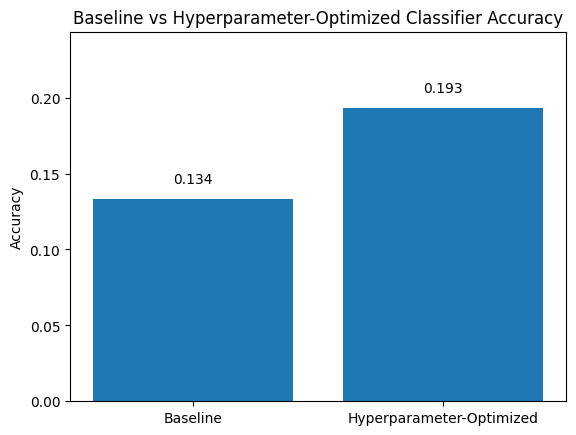

In [ ]:
# Simple bar plot of accuracies
fig, ax = plt.subplots()
ax.bar(results_df["model"], results_df["accuracy"])
ax.set_ylabel("Accuracy")
y_max = results_df["accuracy"].max()
ax.set_ylim(0, y_max + 0.05)
ax.set_title("Baseline vs Hyperparameter-Optimized Classifier Accuracy")
for i, v in enumerate(results_df["accuracy"]):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()

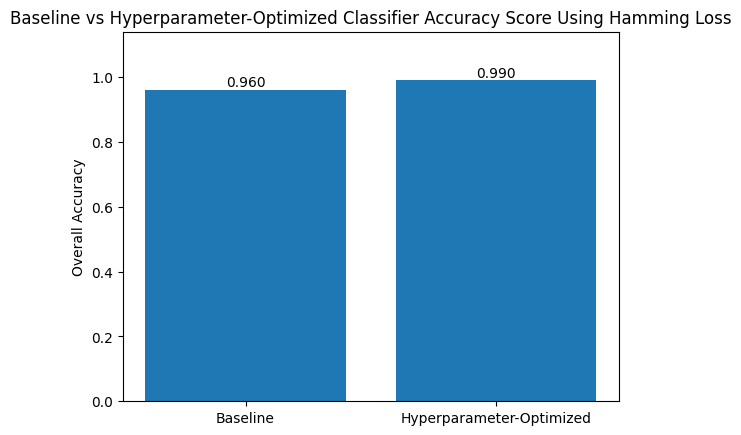

In [ ]:
# Simple bar plot of accuracies
fig, ax = plt.subplots()
ax.bar(results_df["model"], results_df["Overall Accuracy"])
ax.set_ylabel("Overall Accuracy")
y_max = results_df["Overall Accuracy"].max()
ax.set_ylim(0, y_max + 0.15)
ax.set_title("Baseline vs Hyperparameter-Optimized Classifier Accuracy Score Using Hamming Loss")
for i, v in enumerate(results_df["Overall Accuracy"]):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()

In [ ]:
temp = baseline_clf.predict(["disappointed!"])
print(goemotions_labels)
print(temp)

temp_df = pd.DataFrame(temp, columns=goemotions_labels)

print("\nPrediction as DataFrame with labels:")
display(temp_df)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Prediction as DataFrame with labels:


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


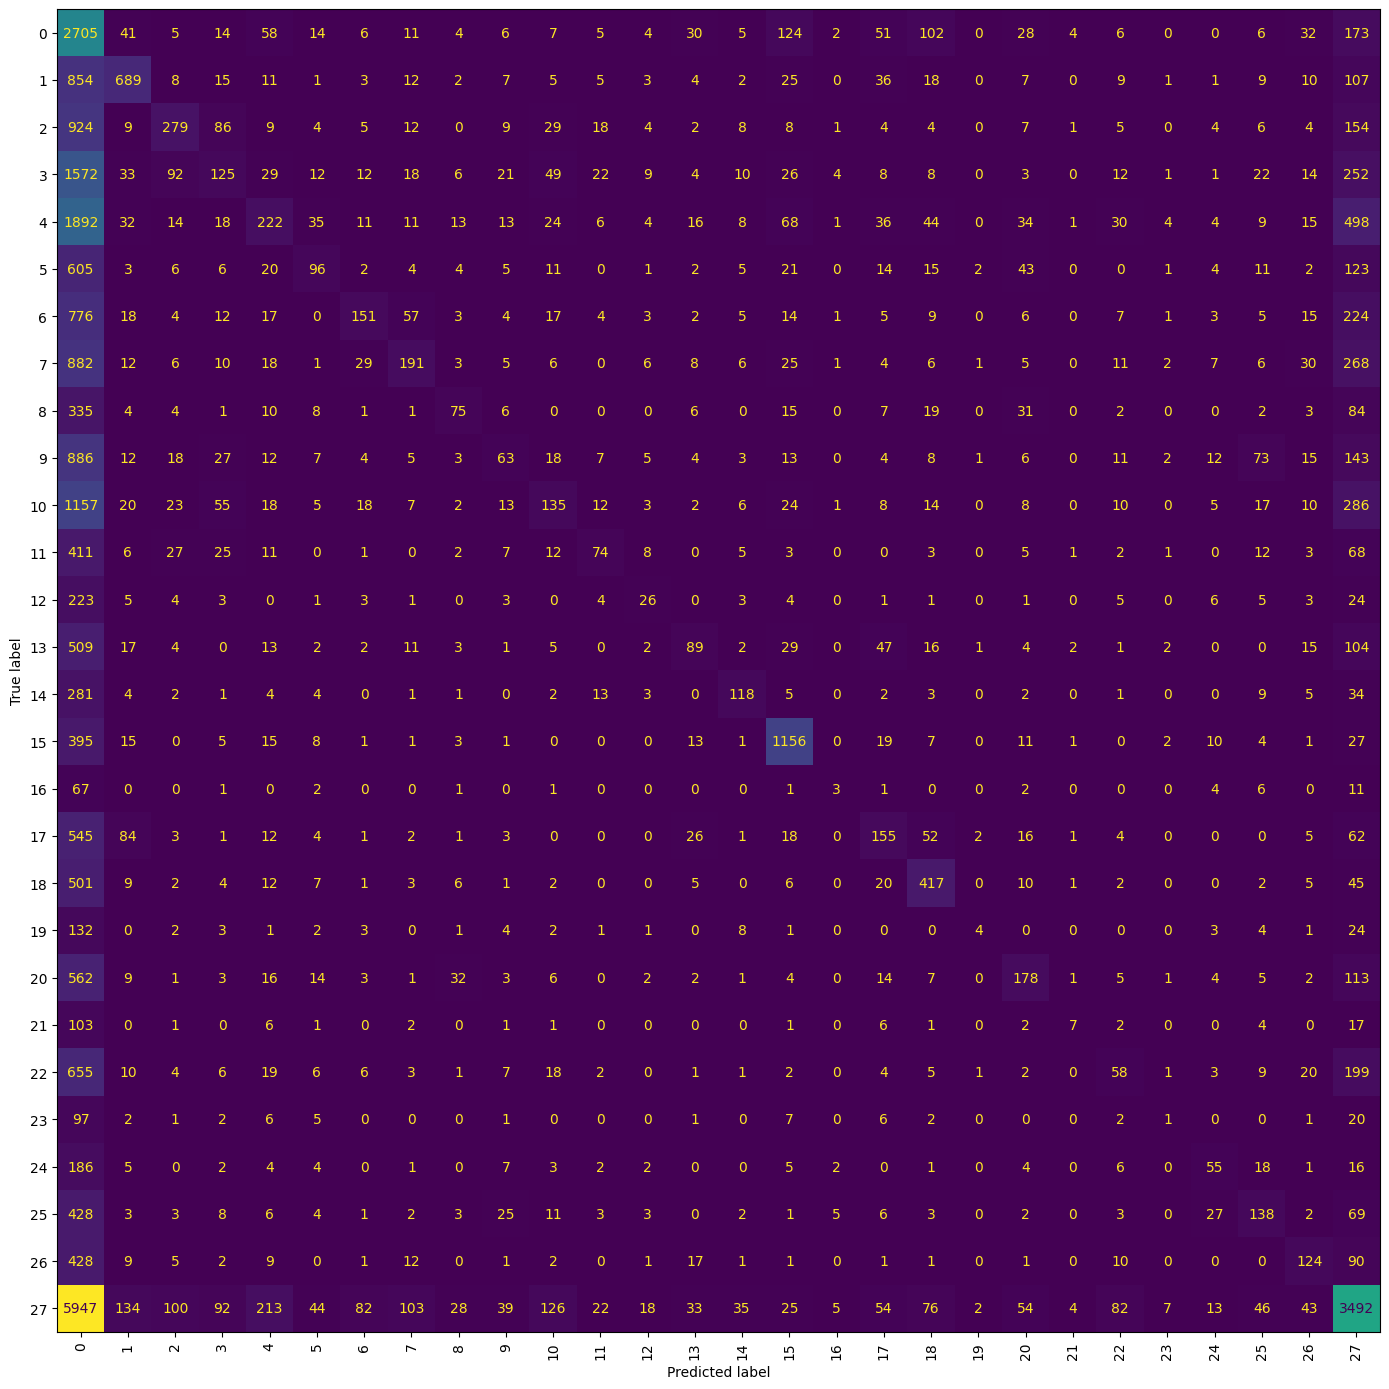

In [ ]:

y_pred_classes = np.argmax(y_pred_best, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(14, 14))
ConfusionMatrixDisplay(cm).plot(
    ax=ax,
    xticks_rotation="vertical",
    colorbar=False
)

plt.tight_layout()
plt.show()